# Brownlow ML Sandbox

This notebook contains a minimal working MLP to predict the 2021 Brownlow vote. 

## Imports

In [ ]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
import torch
import torch.optim as optim
from torch.nn.modules.loss import MSELoss
import glob

In [ ]:
torch.manual_seed(123)
os.chdir('c:\\Users\\gabri\\Dropbox\\Repos\\GoodmanDennisML\\AFL')
os.getcwd()

## Column Name class

In [3]:
class LongFormColumnNames():
    INDEX = 'index'
    PLAYER = 'player'
    TEAM = 'team'
    ROUND = 'round'
    OPPENENT = 'opponents'
    STAT = 'stat'
    VALUE = 'value'
    YEAR ='year'


In [4]:
files = glob.glob('data\\afl_table_data\\AFL-Tables_game-by-game-stats_*.parquet')
years = [f.split('_')[-1].split('.')[0] for f in files]
data = []
for i, f in enumerate(files):
    df = pd.read_parquet(f,engine='fastparquet')
    df[LongFormColumnNames.YEAR] = years[i]
    data.append(df)
df = pd.concat(data,ignore_index=True)
df.head()

,index,player,team,round,opponents,stat,value,year
0,0,"Alvin, Tom",carlton,0,HW,disposals,14,1986
1,1,"Alvin, Tom",carlton,1,RI,disposals,14,1986
2,2,"Alvin, Tom",carlton,2,SK,disposals,22,1986
3,3,"Alvin, Tom",carlton,3,FI,disposals,23,1986
4,4,"Alvin, Tom",carlton,4,ES,disposals,22,1986


In [5]:
df = df.loc[
    (df[LongFormColumnNames.VALUE] != "Off") & (df[LongFormColumnNames.VALUE] != "On")
]

NaN_key = {"NA": np.NaN}
df[LongFormColumnNames.VALUE] = df[LongFormColumnNames.VALUE].replace(NaN_key)

df[LongFormColumnNames.VALUE] = df[LongFormColumnNames.VALUE].astype(np.float32)


In [6]:
df = df.pivot(
    index=[        
        LongFormColumnNames.PLAYER,
        LongFormColumnNames.TEAM,
        LongFormColumnNames.ROUND,
        LongFormColumnNames.OPPENENT,
        LongFormColumnNames.YEAR,
    ],
    columns= LongFormColumnNames.STAT,
    values= LongFormColumnNames.VALUE,
).reset_index()

df = df.drop(columns = 'subs')

In [7]:
df = df.astype({'year':np.int32})
df_2021 = df[(df['round'] < 23) & (df['year'] == 2021)]
df = df[(df['round'] < 23) & (df['year'] >= 2000) & (df['year'] < 2021)]


In [9]:
df = df.fillna(0)


xlabels = [
    "team",
    "opponents",
    "%_played",
    "behinds",
    "bounces",
    "clangers",
    "clearances",
    "contested_marks",
    "contested_possessions",
    "disposals",
    "frees",
    "frees_against",
    "goal_assists",
    "goals",
    "handballs",
    "hit_outs",
    "inside_50s",
    "kicks",
    "marks",
    "marks_inside_50",
    "one_percenters",
    "rebounds",
    "tackles",
    "uncontested_possessions",
]

y_labels = "brownlow_votes"


In [10]:
df.head()

stat,player,team,round,opponents,year,%_played,behinds,bounces,brownlow_votes,clangers,...,handballs,hit_outs,inside_50s,kicks,marks,marks_inside_50,one_percenters,rebounds,tackles,uncontested_possessions
0,"Aarts, Jake",richmond,0,CA,2020,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Aarts, Jake",richmond,1,CW,2020,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Aarts, Jake",richmond,2,HW,2020,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,"Aarts, Jake",richmond,3,SK,2020,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,"Aarts, Jake",richmond,4,ME,2020,82.0,1.0,1.0,0.0,1.0,...,9.0,0.0,1.0,6.0,3.0,0.0,1.0,0.0,2.0,8.0


In [13]:
X = df.drop(columns = ['player', 'team','opponents','round','year', 'brownlow_votes'])
Y = df['brownlow_votes']



In [14]:
X

stat,%_played,behinds,bounces,clangers,clearances,contested_marks,contested_possessions,disposals,frees,frees_against,...,handballs,hit_outs,inside_50s,kicks,marks,marks_inside_50,one_percenters,rebounds,tackles,uncontested_possessions
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,82.0,1.0,1.0,1.0,0.0,0.0,8.0,15.0,0.0,0.0,...,9.0,0.0,1.0,6.0,3.0,0.0,1.0,0.0,2.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477941,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
477942,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
477943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
477944,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
X,Y = torch.tensor(X.to_numpy(), dtype=torch.float),torch.tensor(Y.to_numpy(),dtype=torch.float)
# Y = Y.type(torch.LongTensor)

In [16]:
# Build a class for the neural network 
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()

    self.hidden1 = nn.Sequential(nn.Linear(X.shape[1], 100), 
                               nn.ReLU())
    
    self.hidden2 = nn.Sequential(nn.Linear(100,50), 
                               nn.ReLU())

    self.output = nn.Linear(50, 1)

  def forward(self,x):
    x = self.hidden1(x)

    x = self.hidden2(x)

    x = self.output(x)

    return x

In [90]:
MLP_loss = []

def train(X = X,
          Y = Y,    
          loss_function=nn.MSELoss(),
          epoch_num = 100,  
          batch_size= 100,
          lr=0.0001,):
  

  network = Net()
  network.train()

  data_tuple = [[X[i], Y[i]] for i in range(len(X))] #accuracy 

  batch = torch.utils.data.DataLoader(data_tuple, 
                                      batch_size=batch_size, 
                                      shuffle=True)
  
  optimizer = optim.Adam(network.parameters(), 
                         lr=lr,
                         betas=(0.9, 0.999))

  for epoch in range(epoch_num):

    if not epoch % 10:
      print("Iteration: ", epoch , "Completion: ", (epoch)/epoch_num)

    running_loss = 0
    
    for batch_shuffle in batch:
      
      x,y = batch_shuffle
      y = y.unsqueeze(1)
      # print(x.shape)

      #Give loss
      optimizer.zero_grad()
      loss = loss_function(network(x),y)
      loss.backward()
      optimizer.step()

      running_loss += loss.item() 

    MLP_loss.append(running_loss/batch_size)     

  return network

network = train()


Iteration:  0 Completion:  0.0
Iteration:  10 Completion:  0.1
Iteration:  20 Completion:  0.2
Iteration:  30 Completion:  0.3
Iteration:  40 Completion:  0.4
Iteration:  50 Completion:  0.5
Iteration:  60 Completion:  0.6
Iteration:  70 Completion:  0.7
Iteration:  80 Completion:  0.8
Iteration:  90 Completion:  0.9


In [91]:
torch.save(network.state_dict(), 'model_state.pickle')

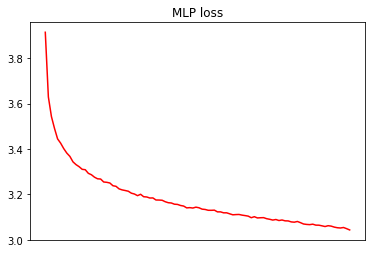

In [94]:
plt.plot(np.arange(0,len(MLP_loss)), MLP_loss, color='red')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)  # labels along the bottom edge are off
plt.title('MLP loss')
plt.show()

In [ ]:
pred = network(X).detach().numpy()


In [23]:
len(pred)

282529

In [24]:
df_2021 = df_2021.fillna(0)
X_test = df_2021[xlabels]
X_test = df_2021.drop(columns = ['player', 'team','opponents','round','year', 'brownlow_votes'])
X_test = X_test.astype(np.float32)
X_test = torch.tensor(X_test.to_numpy(), dtype=torch.float)

In [95]:
#X_test = torch.tensor(X_test, dtype=torch.float)
network.eval()
pred_2021 = network(X_test).detach().numpy()

In [96]:
pred_2021 = [i[0] for i in pred_2021]

14915

In [97]:
df_2021['game_weight'] = pred_2021


count    14915.000000
mean         0.070757
std          0.226547
min         -0.137846
25%          0.004749
50%          0.009268
75%          0.024649
max          3.185950
Name: game_weight, dtype: float64

In [35]:
key_team = {
    "adelaide" : 'AD',
    "brisbaneb" : 'BB',
    "brisbanel" : 'BL',
    "carlton" : 'CA',
    "collingwood" : 'CW',
    "essendon" : 'ES',
    "fitzroy" : 'FI',
    "fremantle" : 'FR',
    "geelong" : 'GE',
    "goldcoast" : 'GC',
    "gws" :'GW',
    "hawthorn"  : "HW",
    "melbourne" : 'ME',
    "kangaroos" : 'NM',
    "padelaide" :'PA' ,
    "richmond" : 'RI',
    "stkilda" : 'SK',
    "swans" : 'SY',
    "westcoast" : 'WC',
    "bullldogs" : 'WB',
}
#key_team = {value:key for key, value in key_team.items()}
df_2021['team']  = df_2021['team'].replace(key_team)


In [54]:
list_sets = []

for row in df_2021[['team', 'opponents', 'round']].iterrows():

    team, opponent, r = row[1]['team'], row[1]['opponents'], str(row[1]['round'])
    ls = [team, opponent, r]
    ls.sort()    
    
    list_sets.append('_'.join(ls))


In [57]:
df_2021['game_id'] = list_sets

In [99]:
games = []
for  game  in df_2021.groupby('game_id'):   
    game_df = game[1].nlargest(n=3, columns='game_weight')
    game_df['votes'] = [3,2,1]
    games.append(game_df)
  
game_df = pd.concat(games, axis=0)
game_df.shape

(612, 31)

In [101]:
game_df[['player', 'votes']].groupby('player').sum().sort_values('votes', ascending=False).head(10)

stat,votes
player,
"Wines, Ollie",40
"Steele, Jack",37
"Mitchell, Tom",35
"Macrae, Jack",33
"Oliver, Clayton",31
"Miller, Touk",29
"Bontempelli, Marcus",28
"Parker, Luke",28
"Parish, Darcy",28


In [ ]:
from tabulate import tabulate
names_all = [i[0] for i in g2]
names = [names_all[i] for i in best]
vote = [pred_2020[i] for i in best]

print(len(vote), len(names))

tab = pd.DataFrame({'Player' :names,'Votes' : vote})
print(tabulate(tab, headers='keys', tablefmt='psql'))

10 10
+----+---------------------+---------+
|    | Player              |   Votes |
|----+---------------------+---------|
|  0 | Jack Macrae         | 8.92466 |
|  1 | Patrick Dangerfield | 8.47176 |
|  2 | Travis Boak         | 8.37097 |
|  3 | Ollie Wines         | 7.53164 |
|  4 | Patrick Cripps      | 5.84249 |
|  5 | Nat Fyfe            | 4.04951 |
|  6 | Todd Goldstein      | 3.75999 |
|  7 | Bailey Smith        | 3.62594 |
|  8 | David Mundy         | 3.5632  |
|  9 | Scott Pendlebury    | 3.38217 |
+----+---------------------+---------+
